Partly taken from https://www.tensors.net/p-dmrg

In [1]:
# -*- coding: utf-8 -*-
"""
mainDMRG_MPO.py
---------------------------------------------------------------------
Script file for initializing the Hamiltonian of a 1D spin chain as an MPO \
before passing to the DMRG routine.

    by Glen Evenbly (c) for www.tensors.net, (v1.1) - last modified 19/1/2019
"""

#### Preamble
import numpy as np
from scipy import linalg as LA
import matplotlib.pyplot as plt

#from ncon import ncon
from tensornetwork.ncon_interface import ncon
from doDMRG_MPO_mine import doDMRG_MPO

import tensornetwork as tn
import math
from numpy import *

In [2]:
def createMPS(num):    
    c=[]
    for i in range(N):
        c.append(tn.Node(num[i]))
    for i in range(N-1):
        c[i][2] ^ c[i+1][0]
    return c

In [3]:
def conjMPS(mps):
    c=[]
    for i in range(N):
        c.append(tn.conj(mps[i]))
    for i in range(1,N-1):
        c[i][2] ^ c[i+1][0]
    return c

In [4]:
def rightcollapsePsiPsi(mps1,mps2,l):
    node = mps1[N-1] @ mps2[N-1]
    for i in range(N-2,l-1,-1):
        node = mps1[i] @ node
        node = node @ mps2[i]
    return node.tensor

In [5]:
def getrhoin(num,k):
    mps2 = createMPS(num)
    mps1 = conjMPS(mps2)
    for i in range(N):
        mps1[i][1] ^ mps2[i][1]
    tensor4 = rightcollapsePsiPsi(mps1,mps2,k+1)
    if k==N-2:
        matrix = tensor4[:,0,:,0]
    else:
        matrix = tensor4[:,0,0,:]
    return matrix

In [6]:
def calcEntrdiag(rhoin):
    diagrhoin = np.diag(np.diag(rhoin))
    lndiagrhoin = LA.logm(diagrhoin)
    entr = -np.trace(np.dot(diagrhoin,lndiagrhoin))
    return entr

In [7]:
def calcEntrsing(rhoin):
    u,s,vh = LA.svd(rhoin, full_matrices=False)
    smatrix = np.diag(s)
    lnsmatrix = LA.logm(smatrix)
    entr = -np.trace(np.dot(smatrix,lnsmatrix))
    return entr

In [8]:
def ground_state():
    #print('h =',h)
    global chi
    #### Define Hamiltonian MPO (quantum XX model)
    global chid
    chid = 2
    sX = 0.5*np.array([[0, 1], [1, 0]])
    sZ = 0.5*np.array([[1, 0], [0,-1]])
    sI = np.array([[1, 0], [0, 1]])
    M = np.zeros([3,3,chid,chid]);
    M[0,0,:,:] = sI
    M[1,0,:,:] = sZ
    M[2,0,:,:] = h*sZ + g*sX
    M[2,1,:,:] = -sZ
    M[2,2,:,:] = sI

    ML = np.array([0,0,1]).reshape(3,1,1) #left MPO boundary
    MR = np.array([1,0,0]).reshape(3,1,1) #right MPO boundary

    #### Initialize MPS tensors
    A = [0 for x in range(N)]
    A[0] = np.random.rand(1,chid,min(chi,chid))
    for k in range(1,N):
        A[k] = np.random.rand(A[k-1].shape[2],chid,min(min(chi,A[k-1].shape[2]*chid),chid**(N-k-1)))

    #### Do DMRG sweeps (2-site approach)
    En1, A, sWeight, B = doDMRG_MPO(A,ML,M,MR,chi, numsweeps = OPTS_numsweeps, dispon = OPTS_dispon, updateon = OPTS_updateon, maxit = OPTS_maxit, krydim = OPTS_krydim)

    #### Increase bond dim and reconverge
    chi = 32;
    En2, A, sWeight, B = doDMRG_MPO(A,ML,M,MR,chi, numsweeps = OPTS_numsweeps, dispon = OPTS_dispon, updateon = OPTS_updateon, maxit = OPTS_maxit, krydim = OPTS_krydim)
    
    return A

In [9]:
def printentrhdensmatr():
    global h
    print()
    print('Entanglement entropy for the central position for different values of h:')

    entr = []
    for it in range(11):
        h = it/10
        m = ground_state()
        rhoin=getrhoin(m,N//2)
        entr.append(calcEntrdiag(rhoin))
        print('h =',h,':',entr[it])
    
    arange = linspace(0, 1, 11)

    f = plt.figure(figsize=(18, 10))
    plt.plot(arange, entr, 'bs')
    #plt.legend()
    plt.xlabel("h", fontsize=20)
    plt.ylabel("Entanglement entropy for the central position", fontsize=20)
    #plt.yscale('log')
    plt.axis('tight')
    plt.show()
    
    #printEntr(A)

In [10]:
def printentrlocdensmatr():
    global h
    h=0.5
    m=ground_state()
    
    entrloc = []
    print('g =',g)
    print('h =',h)
    print('Entanglement entropy for different positions:')
    for i in range(N-1):
        rhoin=getrhoin(m,i)
        entrloc.append(calcEntrdiag(rhoin))
        print('Position = ', i,': ',entrloc[i])
    
    arange = np.arange(N-1)
    #print(arange)

    ff = plt.figure(figsize=(18, 10))
    plt.plot(arange, entrloc, 'bs')
    #plt.legend()
    plt.xlabel("Position", fontsize=20)
    plt.ylabel("Entanglement entropy", fontsize=20)
    #plt.yscale('log')
    plt.axis('tight')
    plt.show()

The length of the Ising spin chain: 100
H = - ZZ + hZ + gX
Z = 0.5*sigmaZ
X = 0.5*sigmaX
g = 1.05

Entanglement entropy for the central position for different values of h:
h = 0.0 : 0.08131837354983955
h = 0.1 : 0.06753241567421912
h = 0.2 : 0.04540530738409847
h = 0.3 : 0.029527672016041638
h = 0.4 : 0.01962327601161533
h = 0.5 : 0.01343917543898009
h = 0.6 : 0.009463591986705317
h = 0.7 : 0.006825767941405639
h = 0.8 : 0.005024958993320662
h = 0.9 : 0.003764881683877593
h = 1.0 : 0.0028642489019194495


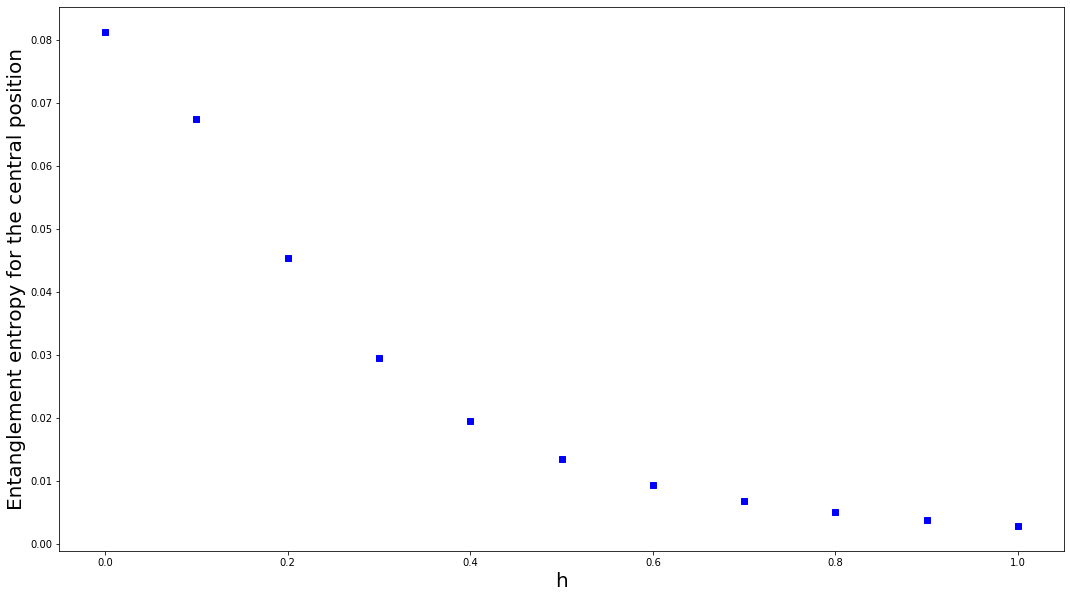

g = 1.05
h = 0.5
Entanglement entropy for different positions:
Position =  0 :  0.020884183934938447
Position =  1 :  0.015191555843790656
Position =  2 :  0.01379284316156678
Position =  3 :  0.013508743210997353
Position =  4 :  0.013452782624913659
Position =  5 :  0.013441817018154745
Position =  6 :  0.013439669710613129
Position =  7 :  0.013439249231376547
Position =  8 :  0.013439166706953037
Position =  9 :  0.013439151320859216
Position =  10 :  0.013439147782867976
Position =  11 :  0.013439147476359912
Position =  12 :  0.013439147939069192
Position =  13 :  0.013439147926943751
Position =  14 :  0.013439147106104577
Position =  15 :  0.013439144463694822
Position =  16 :  0.013439147325766057
Position =  17 :  0.013439147160011036
Position =  18 :  0.013439147157258722
Position =  19 :  0.013439147082841166
Position =  20 :  0.01343914696417366
Position =  21 :  0.013439147324375992
Position =  22 :  0.013439146647785578
Position =  23 :  0.013439146777462127
Position =  2

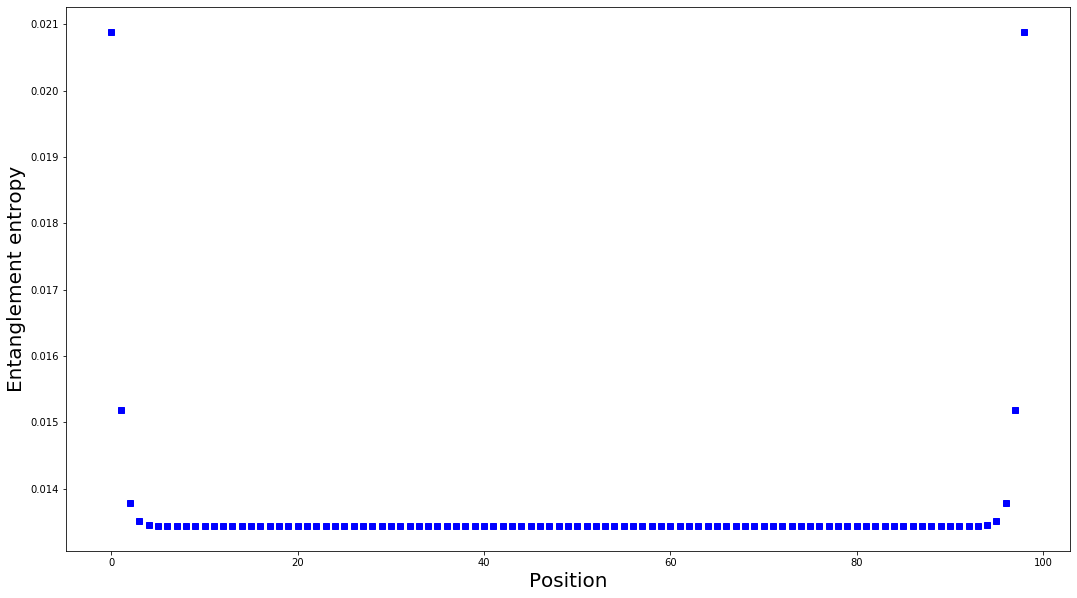

In [12]:
##### -ZZ+hZ+gX model #############
#######################################

##### Set bond dimensions and simulation options
chi = 16
chid = 2
N = 100
print('The length of the Ising spin chain:',N)
print('H = - ZZ + hZ + gX')
print('Z = 0.5*sigmaZ')
print('X = 0.5*sigmaX')
g = 1.05
print('g =',g)

OPTS_numsweeps = 4 # number of DMRG sweeps
OPTS_dispon = 0 # level of output display
OPTS_updateon = True # level of output display
OPTS_maxit = 2 # iterations of Lanczos method
OPTS_krydim = 4 # dimension of Krylov subspace

acc = 6

printentrhdensmatr()
printentrlocdensmatr()